In [1]:
# Importing packages

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, K, Reshape, LSTM, CuDNNLSTM
from keras.utils import np_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from os.path import isfile

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class1 = {0:'NEUTROPHIL',1:'EOSINOPHIL',2:'MONOCYTE',3:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}

In [3]:
wbc = pd.read_csv('./labels.csv')
wbc.head(11)

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL
5,NaN,5,NEUTROPHIL
6,NaN,6,NEUTROPHIL
7,NaN,7,NEUTROPHIL
8,NaN,8,BASOPHIL
9,NaN,9,EOSINOPHIL


In [4]:
wbc = wbc.drop(columns=['Unnamed: 0']).dropna()

In [5]:
wbc2 = wbc[~wbc["Category"].str.contains(",", na=False)]['Category']

In [6]:
wbc.shape

(367, 2)

In [7]:
wbc2.shape

(352,)

[  3  88  33  21 207]


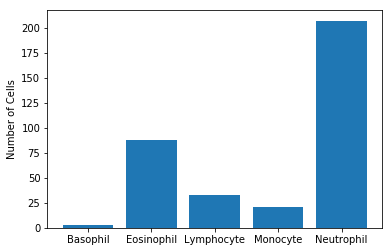

In [8]:
encoder = LabelEncoder()
encoder.fit(wbc2)
encoded_y = encoder.transform(wbc2)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Number of Cells');

Only three labels of basophil will lead to imbalanced calsses. Therefore, I won't include them in our model.

In [9]:
def get_data(folder):                          #    Load the data and labels from the given folder.
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        print(wbc_type)
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 0
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 2  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 3 
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(30,30), interpolation=cv2.INTER_CUBIC)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)

    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

In [10]:
X_train, y_train, z_train = get_data('./images/TRAIN/')
X_test, y_test, z_test = get_data('./images/TEST/')

  0%|          | 0/1000 [00:00<?, ?it/s]

LYMPHOCYTE


  6%|▌         | 56/1000 [00:00<00:01, 551.92it/s]

MONOCYTE


  5%|▍         | 48/1000 [00:00<00:02, 475.60it/s]

EOSINOPHIL


  5%|▌         | 54/1000 [00:00<00:01, 537.17it/s]

NEUTROPHIL


  9%|▊         | 53/620 [00:00<00:01, 524.00it/s]

.DS_Store
LYMPHOCYTE


  8%|▊         | 50/620 [00:00<00:01, 494.43it/s]

MONOCYTE


  9%|▉         | 57/623 [00:00<00:01, 559.78it/s]

EOSINOPHIL


  9%|▉         | 55/624 [00:00<00:01, 546.47it/s]

NEUTROPHIL


100%|██████████| 624/624 [00:01<00:00, 534.53it/s]

.DS_Store


In [11]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

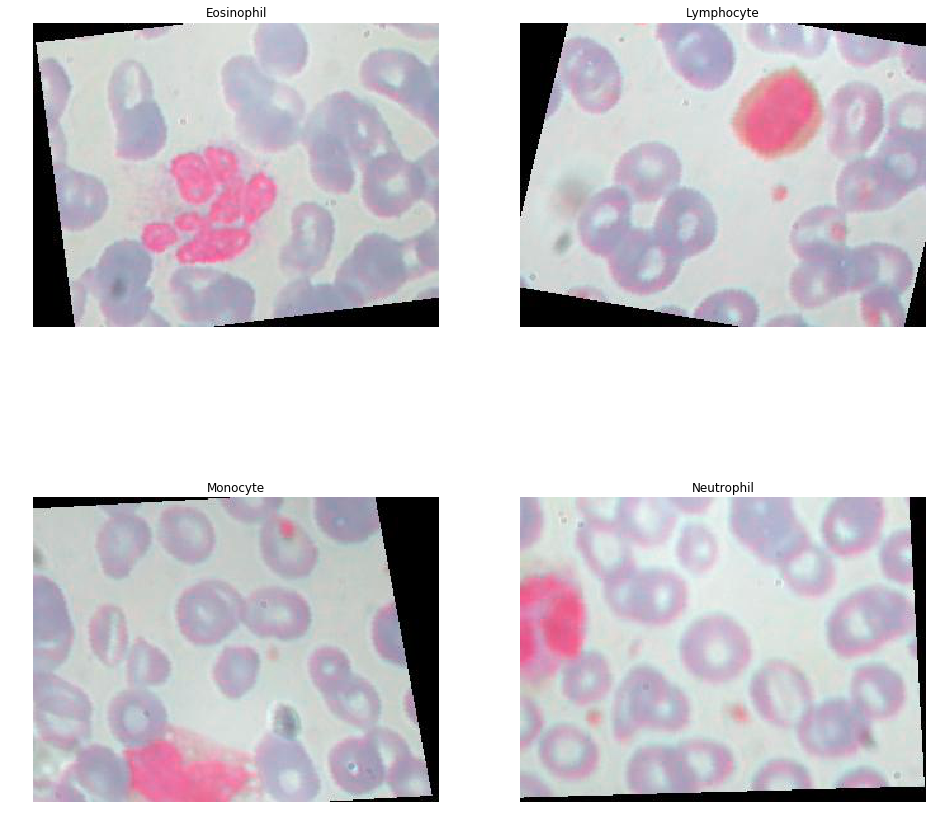

In [12]:
# Plot an image oof the four types of cells
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = './images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = './images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = './images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = './images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}
0    0.25
2    0.25
1    0.25
3    0.25
Name: labels, dtype: float64


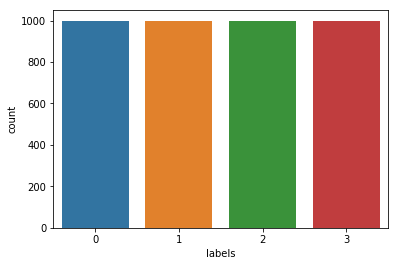

In [13]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(class1)
print(lab.value_counts(normalize=True, ascending = True))

In [14]:
print ('Shape of X train:', X_train.shape)
print ('Shape of y train:', y_train.shape)
print ('Shape of z train:', z_train.shape)



Shape of X train: (3996, 30, 30, 3)
Shape of y train: (3996,)
Shape of z train: (3996,)


In [15]:
# Encode labels to vectors
from keras.utils.np_utils import to_categorical
y_train_hot = to_categorical(y_train, num_classes = 4)
y_test_hot = to_categorical(y_test, num_classes = 4)
z_train_hot = to_categorical(z_train, num_classes = 2)
z_test_hot = to_categorical(z_test, num_classes = 2)
print(class1)
print(class2)

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [16]:
print ('Shape of hot-encoded y train:', y_train_hot.shape)
print ('Shape of hot-encoded y test:', y_test_hot.shape)
print ('Shape of hot-encoded z train:', z_train_hot.shape)
print ('Shape of hot-encoded z test:', z_test_hot.shape)

Shape of hot-encoded y train: (3996, 4)
Shape of hot-encoded y test: (2487, 4)
Shape of hot-encoded z train: (3996, 2)
Shape of hot-encoded z test: (2487, 2)


In [17]:
y_train_hot

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [18]:
X_train.shape

(3996, 30, 30, 3)

In [19]:
X_test.shape

(2487, 30, 30, 3)

In [32]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 16,
                     kernel_size = (3,3),
                     activation = 'relu',
                     input_shape = (30,30,3)))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Conv2D(filters = 32,
                     kernel_size = (3,3),
                     activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128,
                    activation = 'relu'))
cnn_model.add(Dense(64,
                    activation = 'relu'))
cnn_model.add(Dense(32,
                    activation = 'relu'))
cnn_model.add(Dense(16,
                    activation = 'relu'))
cnn_model.add(Dense(8,
                    activation = 'relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(4,
                    activation = 'softmax'))

In [33]:
cnn_model.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(),
                  metrics = ['accuracy'])

# Input more dropout layers
# Decrease epochs

In [34]:
history = cnn_model.fit(X_train,
y_train_hot,
batch_size = 64,
validation_data = (X_test, y_test_hot),
epochs =20)

Train on 3996 samples, validate on 2487 samples
Epoch 1/20
3996/3996 [==============================] - 4s 981us/step - loss: 1.3886 - acc: 0.2543 - val_loss: 1.3863 - val_acc: 0.2509
Epoch 2/20
3996/3996 [==============================] - 2s 576us/step - loss: 1.3865 - acc: 0.2387 - val_loss: 1.3863 - val_acc: 0.2505
Epoch 3/20
3996/3996 [==============================] - 2s 574us/step - loss: 1.3865 - acc: 0.2417 - val_loss: 1.3862 - val_acc: 0.2505
Epoch 4/20
3996/3996 [==============================] - 2s 569us/step - loss: 1.3863 - acc: 0.2365 - val_loss: 1.3861 - val_acc: 0.2493
Epoch 5/20
3996/3996 [==============================] - 2s 569us/step - loss: 1.3863 - acc: 0.2440 - val_loss: 1.3864 - val_acc: 0.2493
Epoch 6/20
3996/3996 [==============================] - 2s 571us/step - loss: 1.3872 - acc: 0.2500 - val_loss: 1.3864 - val_acc: 0.2505
Epoch 7/20
3996/3996 [==============================] - 2s 570us/step - loss: 1.3867 - acc: 0.2435 - val_loss: 1.3863 - val_acc: 0.2493


In [26]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(30,30,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [27]:
model.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])

In [29]:
epochs = 80
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)  

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
history2 = model.fit_generator(datagen.flow(X_train, y_train_hot, 
                                   batch_size=64), 
                                   steps_per_epoch=len(X_train) / 64, 
                                   epochs=epochs, 
                                   validation_data=(X_test, y_test_hot))
                               

Epoch 1/80
63/62 [==============================] - 14s 229ms/step - loss: 1.4060 - acc: 0.2523 - val_loss: 1.3858 - val_acc: 0.2505
Epoch 2/80
63/62 [==============================] - 13s 208ms/step - loss: 1.3882 - acc: 0.2413 - val_loss: 1.3836 - val_acc: 0.2911
Epoch 3/80
63/62 [==============================] - 13s 210ms/step - loss: 1.3859 - acc: 0.2714 - val_loss: 1.3773 - val_acc: 0.2827
Epoch 4/80
63/62 [==============================] - 13s 208ms/step - loss: 1.3827 - acc: 0.2736 - val_loss: 1.3713 - val_acc: 0.2947
Epoch 5/80
63/62 [==============================] - 13s 207ms/step - loss: 1.3732 - acc: 0.2912 - val_loss: 1.3185 - val_acc: 0.4077
Epoch 6/80
63/62 [==============================] - 13s 208ms/step - loss: 1.3468 - acc: 0.3199 - val_loss: 1.2242 - val_acc: 0.4676
Epoch 7/80
63/62 [==============================] - 13s 209ms/step - loss: 1.3117 - acc: 0.3582 - val_loss: 1.1861 - val_acc: 0.4704
Epoch 8/80
63/62 [==============================] - 13s 208ms/step - 

63/62 [==============================] - 13s 208ms/step - loss: 0.3832 - acc: 0.8491 - val_loss: 0.4905 - val_acc: 0.7813
Epoch 63/80
63/62 [==============================] - 13s 207ms/step - loss: 0.4219 - acc: 0.8308 - val_loss: 0.5814 - val_acc: 0.7648
Epoch 64/80
63/62 [==============================] - 13s 207ms/step - loss: 0.4009 - acc: 0.8387 - val_loss: 0.5157 - val_acc: 0.7776
Epoch 65/80
63/62 [==============================] - 13s 208ms/step - loss: 0.5129 - acc: 0.8062 - val_loss: 0.5261 - val_acc: 0.7809
Epoch 66/80
63/62 [==============================] - 13s 209ms/step - loss: 0.3815 - acc: 0.8451 - val_loss: 0.5435 - val_acc: 0.7652
Epoch 67/80
63/62 [==============================] - 13s 208ms/step - loss: 0.3912 - acc: 0.8422 - val_loss: 0.5083 - val_acc: 0.7813
Epoch 68/80
63/62 [==============================] - 13s 208ms/step - loss: 0.3922 - acc: 0.8477 - val_loss: 0.5357 - val_acc: 0.7797
Epoch 69/80
63/62 [==============================] - 13s 208ms/step - loss

In [ ]:
history2.history.keys()

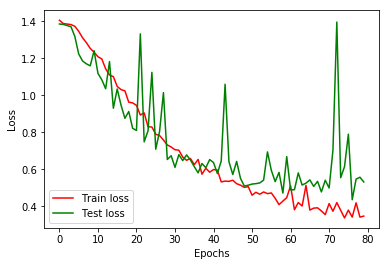

In [30]:
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']

plt.plot(train_loss, label= 'Train loss', color='red')
plt.plot(test_loss, label= 'Test loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();


The score of this model is: <bound method Model.evaluate of <keras.engine.sequential.Sequential object at 0x7f3433077390>>


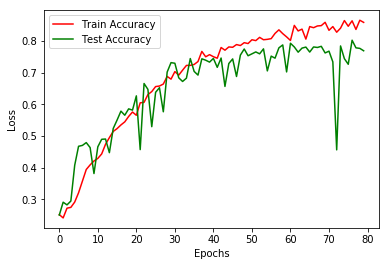

In [37]:
train_acc = history2.history['acc']
test_acc = history2.history['val_acc']

plt.plot(train_acc, label= 'Train Accuracy', color='red')
plt.plot(test_acc, label= 'Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [36]:
score = model.evaluate

In [ ]:
# Underfit: Low accuracy score for both train and test.